In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.style.use('bmh')

In [13]:
import torch
import math

from tqdm import tqdm_notebook
from boltons.iterutils import pairwise
from scipy.stats import kendalltau
from itertools import permutations

from sent_order.models.kt_regression import SentenceEncoder, Regressor, Corpus
from sent_order.perms import sample_uniform_perms

In [3]:
sent_encoder = torch.load(
    '../../data/models/new/kt-reg/sent_encoder.68.bin',
    map_location={'cuda:0': 'cpu'},
)

In [4]:
regressor = torch.load(
    '../../data/models/new/kt-reg/regressor.68.bin',
    map_location={'cuda:0': 'cpu'},
)

/Users/dclure/Projects/plot-ordering/env/lib/python3.6/site-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'sent_order.models.kt_regression.Regressor' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [5]:
train = Corpus('../../data/dev.json/', 10000)

100%|██████████| 10000/10000 [00:01<00:00, 7154.41it/s]


In [6]:
grafs = [g for g in train.grafs if len(g.sentences) == 5]

In [7]:
len(grafs)

1647

In [8]:
graf = grafs[200]

In [9]:
[' '.join(s.tokens) for s in graf.sentences]

['If the spacetime metric has anisotropic spatial curvature , one can afford to expand the universe isotropically , provided that the energy - momentum tensor satisfy a certain con- straint .',
 'This leads to the so - called shear - free metrics , which have the interesting property of violating the cosmological principle while still preserving the isotropy of the cosmic mi- crowave background ( CMB ) radiation .',
 'In this work we show that shear - free cosmologies correspond to an attractor solution in the space of models with anisotropic spatial curva- ture .',
 'Through a rigorous definition of linear perturbation theory in these spacetimes , we show that shear - free models represent a viable alternative to describe the large - scale evo- lution of the universe , leading , in particular , to a kinematically equivalent Sachs - Wolfe effect .',
 'Alternatively , we discuss some specific signatures that shear - free models would imprint on the temperature spectrum of CMB .']

In [10]:
sents = sent_encoder(graf.sentence_variables())

In [11]:
sents

Variable containing:
-1.8941e-03 -5.7180e-03 -1.4973e-02  ...   7.3029e-06  4.4886e-03  1.3571e-04
 3.2571e-05  1.8206e-05 -4.1570e-04  ...   3.1045e-04  8.6798e-05  2.3558e-03
-3.5252e-01 -7.9005e-04 -2.2374e-01  ...  -2.4450e-04  3.4667e-05 -1.2145e-02
-1.7325e-02 -1.6153e-03 -1.0632e-02  ...  -1.0944e-05  2.4214e-04 -3.0673e-05
-6.1275e-02  9.9747e-03 -5.0977e-03  ...   3.4747e-05  4.2625e-01  9.4852e-02
[torch.FloatTensor of size 5x1000]

In [18]:
perms = list(permutations(range(5)))

In [25]:
kts = []
for perm in tqdm_notebook(perms):
    
    sort = torch.LongTensor(perm)
    pred = regressor(sents[sort].unsqueeze(0)).data[0]
    pred = (1-pred)*2-1
    
    kt = kendalltau(perm, range(5)).correlation
    
    kts.append((kt, pred))

HBox(children=(IntProgress(value=0, max=120), HTML(value='')))

In [26]:
kts = sorted(kts, key=lambda x: x[0])

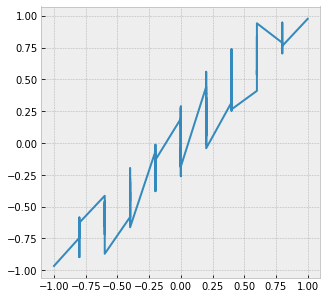

In [27]:
x, y = zip(*kts)

plt.figure(figsize=(5,5))
plt.plot(x, y)